# TensorFlow Datasets

`tf.data` is a hihg-level API for reading data and transforming it into a form used for training. It is designed to work with TensorFlow and makes it easy to load data, manipulate it, and pipe it into a model. In short, It is a low-level API that can be used to build data pipelines. It should not be mistaken something to be used for loading only tensorflow datasets.

## 1. Imports and Configuration

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Configure GPU memory growth to be dynamic instead of allocating all memory at once
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

/home/jay/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1: Datapipeline for Image Classification

- `suffle_files=True` tensorflow usually store data in tf records, which is usually stored in multiple files. This option shuffles the files before loading them. For example for cifar10, there are 6 files, each containing 10,000 images. This seggregation is done to make it easier to **load data in parallel**. Data could be loaded simultaneously while training. If we don't shuffle the files, we will end up loading the same class of images in a batch, which is <ins>not good for training</ins>.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)

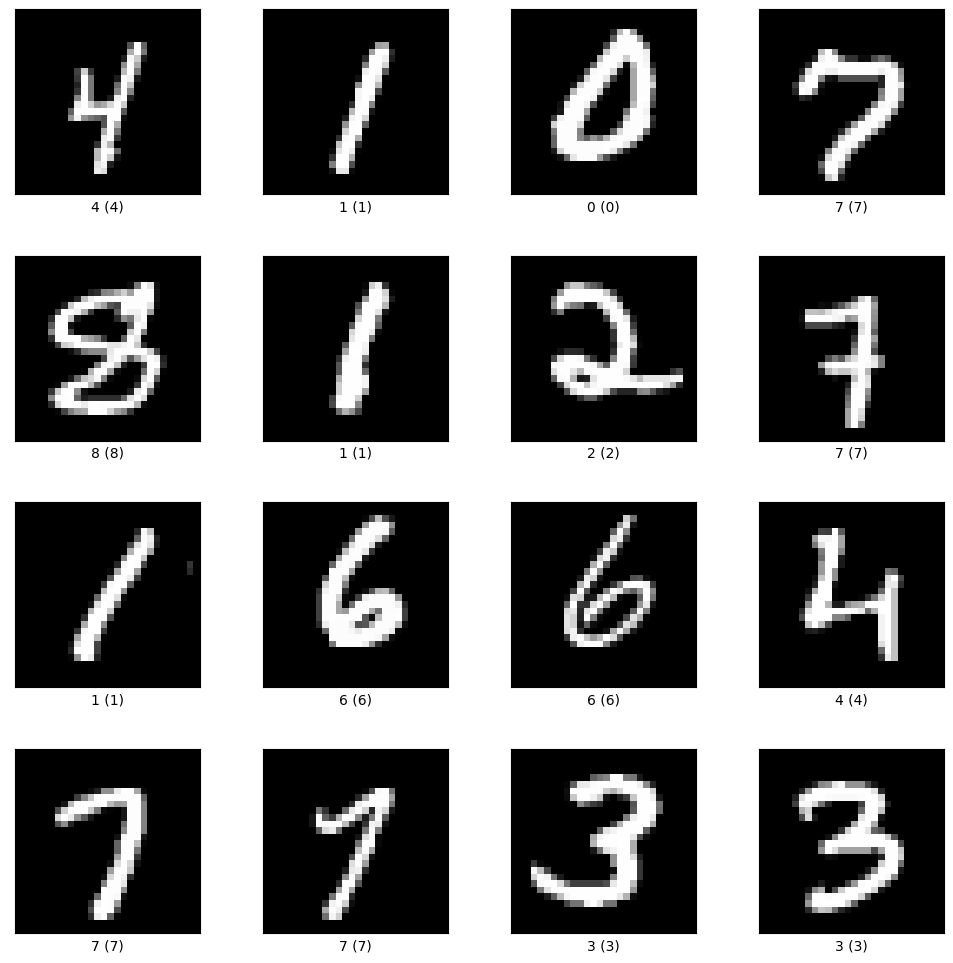

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/jay/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [4]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)
print(ds_info)

In [5]:
def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

"""
This is what we are going to do similarly when we have our own custom dataset.
"""

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
# What prefetch does is that while the 128 images (from batch) are being used to train the model,
# the dataset will start preparing the next batch of images (prefetching) so that they are ready 
# for the GPU once it has finished with the current batch. This reduces the time the GPU has to wait
# for data to be fed to it.
ds_train = ds_train.prefetch(AUTOTUNE)

# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(128)
ds_test = ds_train.prefetch(AUTOTUNE)

In [6]:
# Simple model
model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Compiling and training the model
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# ds_train is a tf.data.Dataset object, which will return a tuple (x:input_data,y:label) when iterated over.
model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
469/469 - 7s - loss: 0.2565 - accuracy: 0.9293
Epoch 2/5
469/469 - 1s - loss: 0.0882 - accuracy: 0.9750
Epoch 3/5
469/469 - 1s - loss: 0.0617 - accuracy: 0.9821
Epoch 4/5
469/469 - 1s - loss: 0.0484 - accuracy: 0.9858
Epoch 5/5
469/469 - 1s - loss: 0.0392 - accuracy: 0.9886
469/469 [==============================] - 1s 2ms/step - loss: 0.0282 - accuracy: 0.9925


[0.028232529759407043, 0.9924666881561279]

## Example 2: Datapipeline for Text Classification